In [ ]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points, get_value_before_comma
from read_data import pull_data, prepare_data, pull_projections
from modeling import split_data, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

FORMAT = "UD" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2024 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 420202469

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [3]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Pulling data for year: 2024
Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully (parquet).
Data pull & feature engineering complete.


In [ ]:
# TODO: Update feature engineering pipeline so that it is a bit cleaner prior to save out
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [4]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points(batting_projections, rules=SCORING_RULES[FORMAT]["bat"], out_col="projected_fantasy_points")
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points(pitching_projections, rules=SCORING_RULES[FORMAT]["pit"], out_col="projected_fantasy_points")
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

# Creating Batting Model

## Creating baseline batting predictions

In [5]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 318.658 | MAE: 253.304 | R^2: 0.463


In [6]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
619     Kris Bryant                 1549.0               1723.022217   
1344     Mike Trout                 1409.0               1714.538086   
959   Anthony Rizzo                 1571.0               1669.436401   
1012    Kris Bryant                  933.0               1635.719727   
1380  Albert Pujols                 1628.0               1553.566406   
...             ...                    ...                       ...   
280      Tyler Wade                  194.0                184.883102   
870      Tomas Nido                  182.0                174.998444   
1475   Gary Bennett                  251.0                171.569580   
1300  Erik Gonzalez                  288.0                143.156113   
534       Tim Lopes                  258.0                133.342346   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
619        174.022217     174.022217    2016   24          1678.0  
1344       305.538086     305.538086    2016   24          1790.0  
959         98.436401      98.436401    2015   25          1617.0  
1012       702.719727     702.719727    2017   25          1549.0  
1380       -74.433594      74.433594    2006   26          1806.0  
...               ...            ...     ...  ...             ...  
280         -9.116898       9.116898    2019   24           215.0  
870         -7.001556       7.001556    2023   29            39.0  
1475       -79.430420      79.430420    2005   33           293.0  
1300      -144.843887     144.843887    2019   27           220.0  
534       -124.657654     124.657654    2019   25           236.0  

[1590 rows x 8 columns]

# Building Final Model

In [7]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.06)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 80, 1),

    "subsample": hp.uniform("subsample", 0.8, 0.95),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.65, 0.95),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.5), np.log(20.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-3), np.log(5.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(5.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(1.0)),
}

# Batting Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=10,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2500,
    early_stopping_rounds=30,
)

100%|██████████| 5/5 [00:19<00:00,  3.96s/trial, best loss: 302.7955009514181]
Best Parameters: {'learning_rate': 0.04070461242819835, 'max_leaves': 17, 'grow_policy': 'lossguide', 'subsample': 0.8062653638984149, 'colsample_bytree': 0.7540541345500078, 'min_child_weight': 0.5533535652205649, 'reg_lambda': 0.006730681002338322, 'reg_alpha': 2.462153377723083, 'gamma': 0.014067791599379606}
[Best trial @ val] optimized=rmse | RMSE=302.796 | MAE=244.213 | ASYM=114458.685


In [ ]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=SEED,
    id_cols=["IDfg"],        
)

Best iteration: 254
[Val] RMSE: 302.796 | MAE: 244.213 | R^2: 0.556 | ASYM: 114458.685
[Test] RMSE: 312.059 | MAE: 247.338 | R^2: 0.485 | ASYM: 119100.837


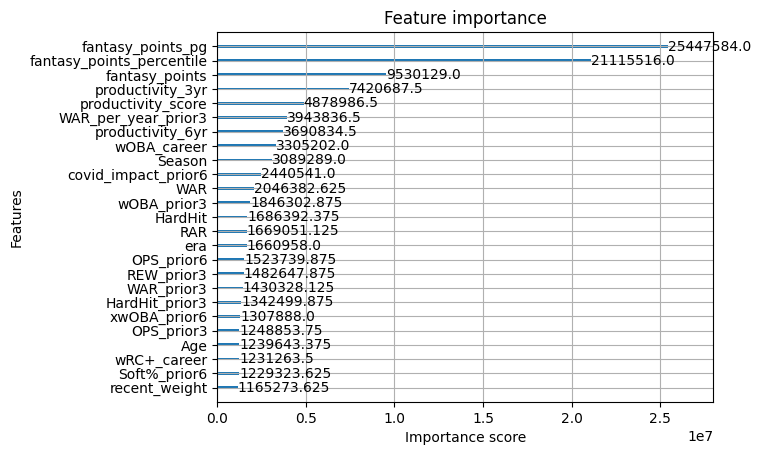

In [113]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [114]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1300     Albert Pujols                 1806.0               1532.389648   
1327  Paul Goldschmidt                 1719.0               1528.360962   
1028     Albert Pujols                 1628.0               1512.010376   
1406  Francisco Lindor                 1449.0               1503.286255   
1334    Prince Fielder                 1552.0               1499.275635   
...                ...                    ...                       ...   
1061    Bubba Starling                   72.0                196.088104   
1235      Andrew Knapp                  187.0                182.568665   
631       Ryan McBroom                  159.0                177.644318   
1451        Sandy Leon                  105.0                176.765594   
215        Pat Valaika                  289.0                154.323196   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1300      -273.610352     273.610352    2005   25          1870.0  
1327      -190.639038     190.639038    2016   28          1679.0  
1028      -115.989624     115.989624    2006   26          1806.0  
1406        54.286255      54.286255    2018   24          1727.0  
1334       -52.724365      52.724365    2011   27          1674.0  
...               ...            ...     ...  ...             ...  
1061       124.088104     124.088104    2019   26           283.0  
1235        -4.431335       4.431335    2019   27           231.0  
631         18.644318      18.644318    2019   27           133.0  
1451        71.765594      71.765594    2019   30           251.0  
215       -134.676804     134.676804    2019   26           123.0  

[1590 rows x 8 columns]

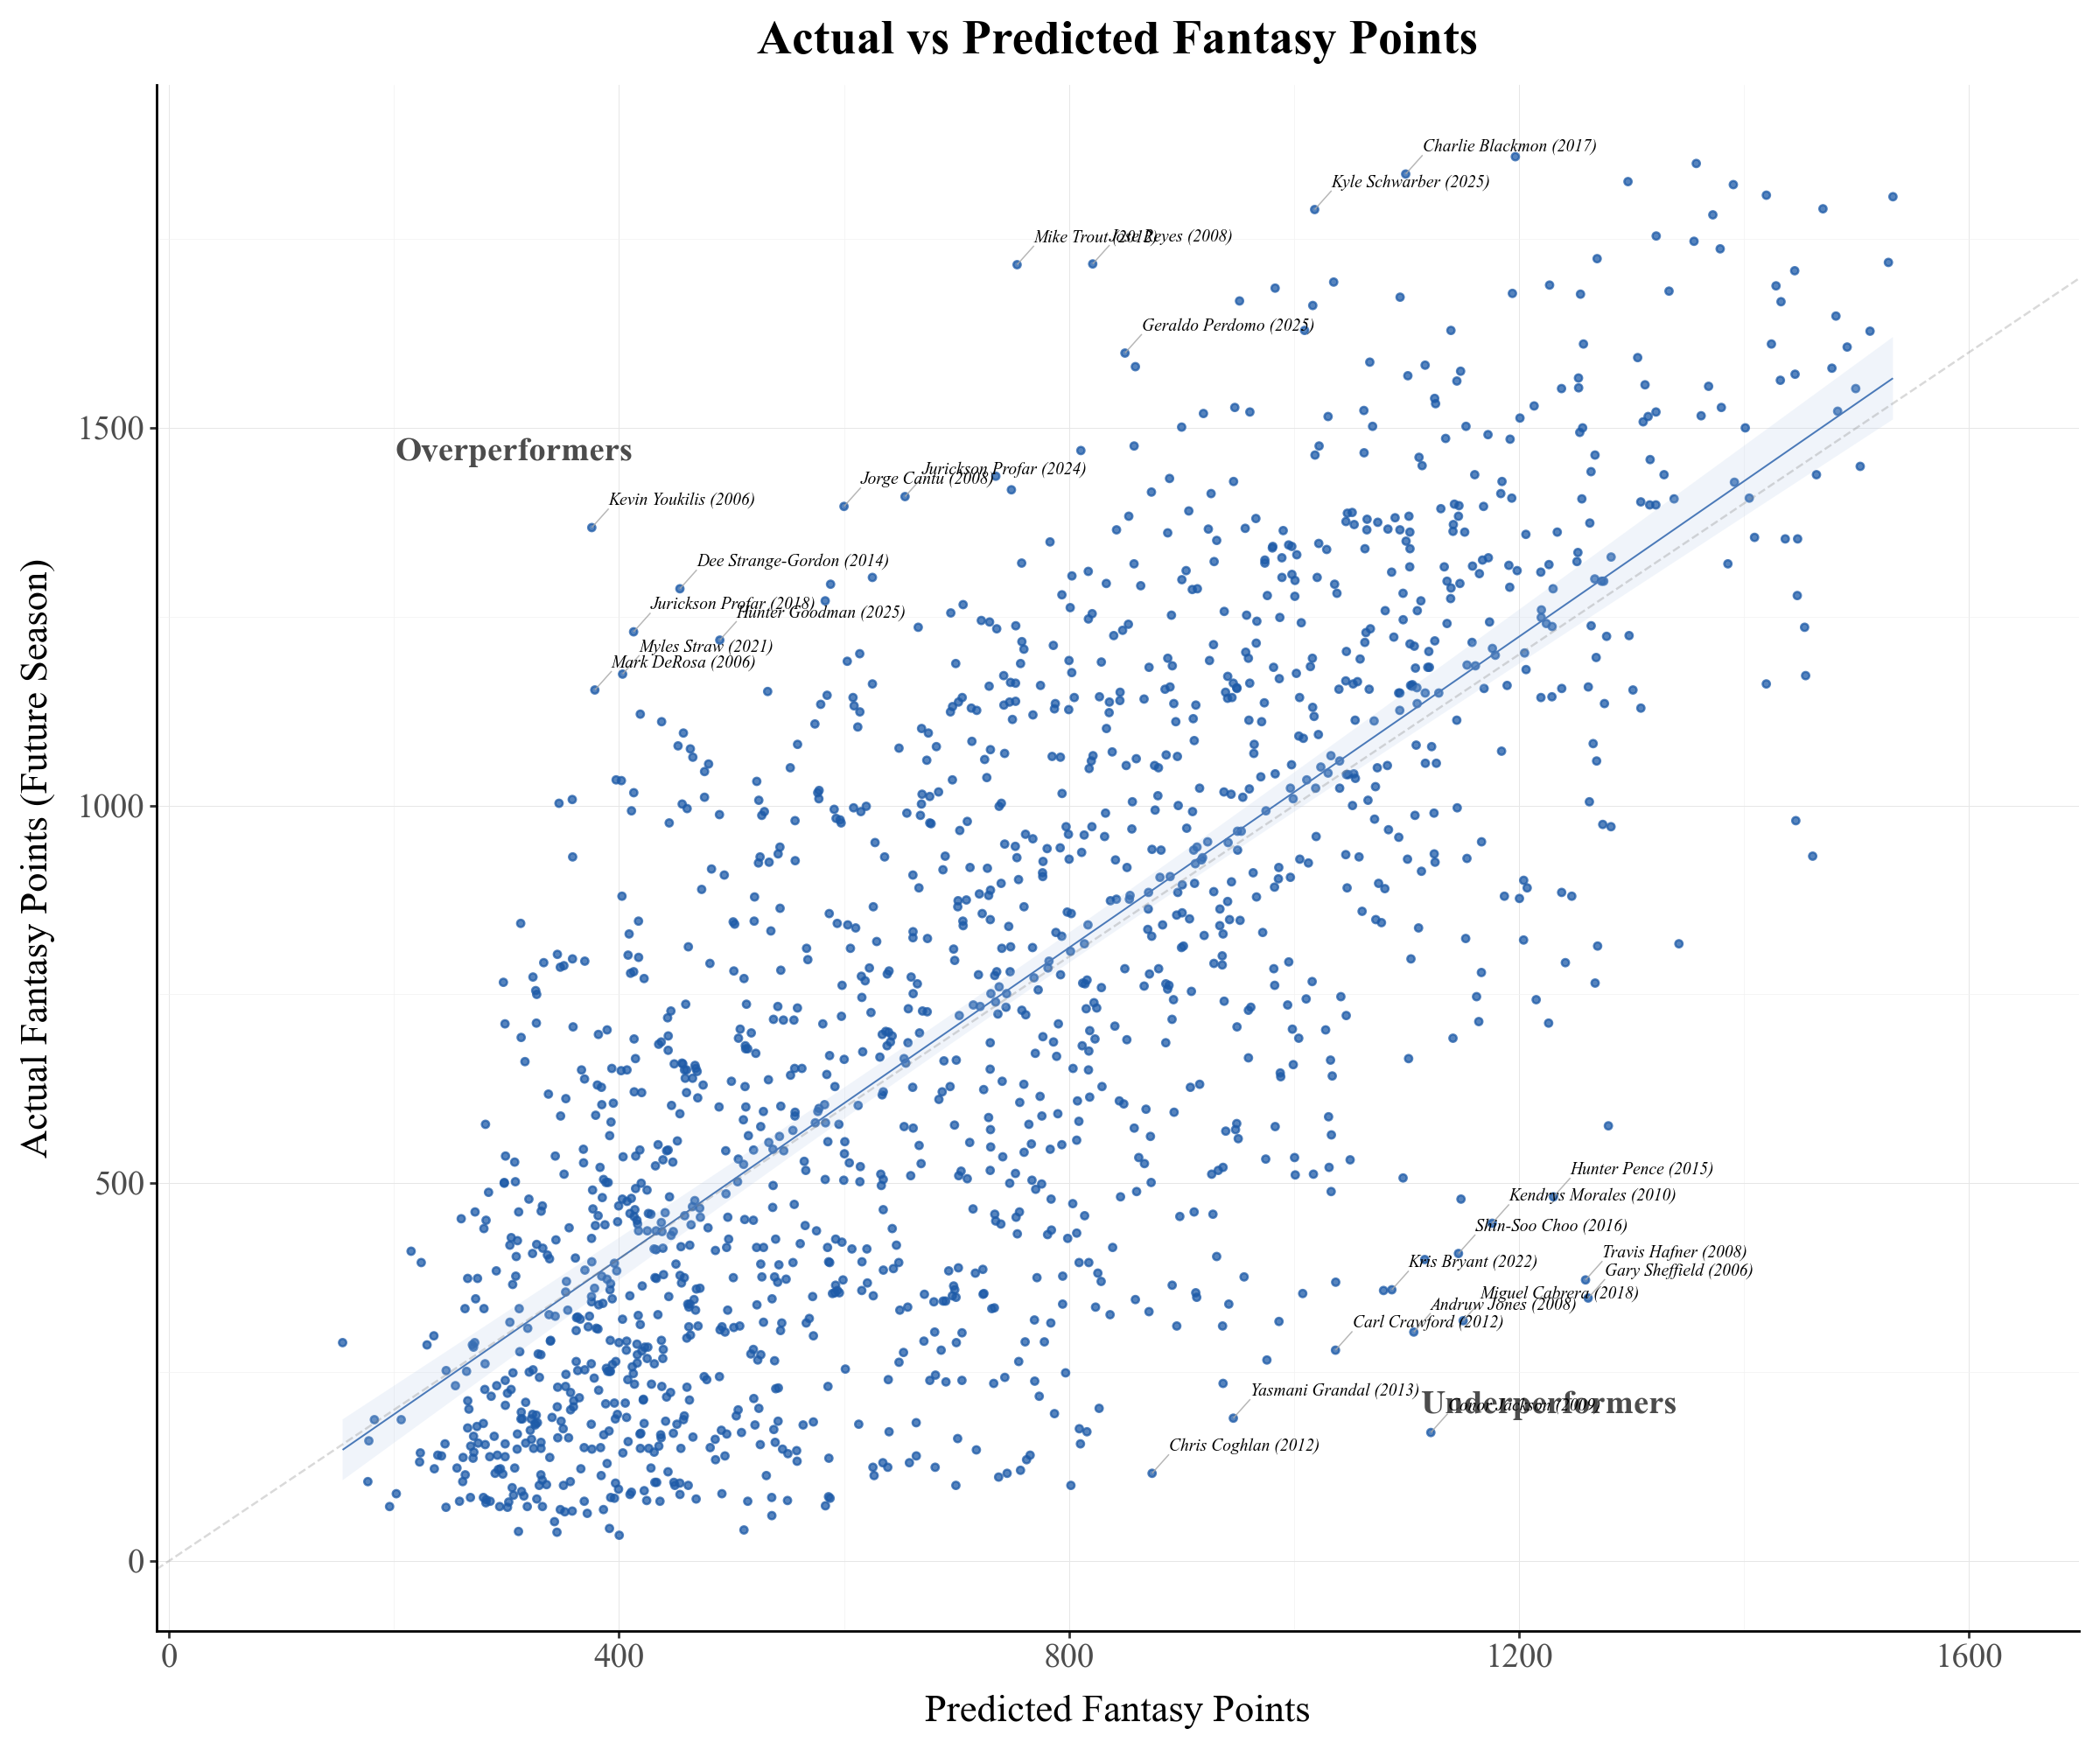

In [115]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

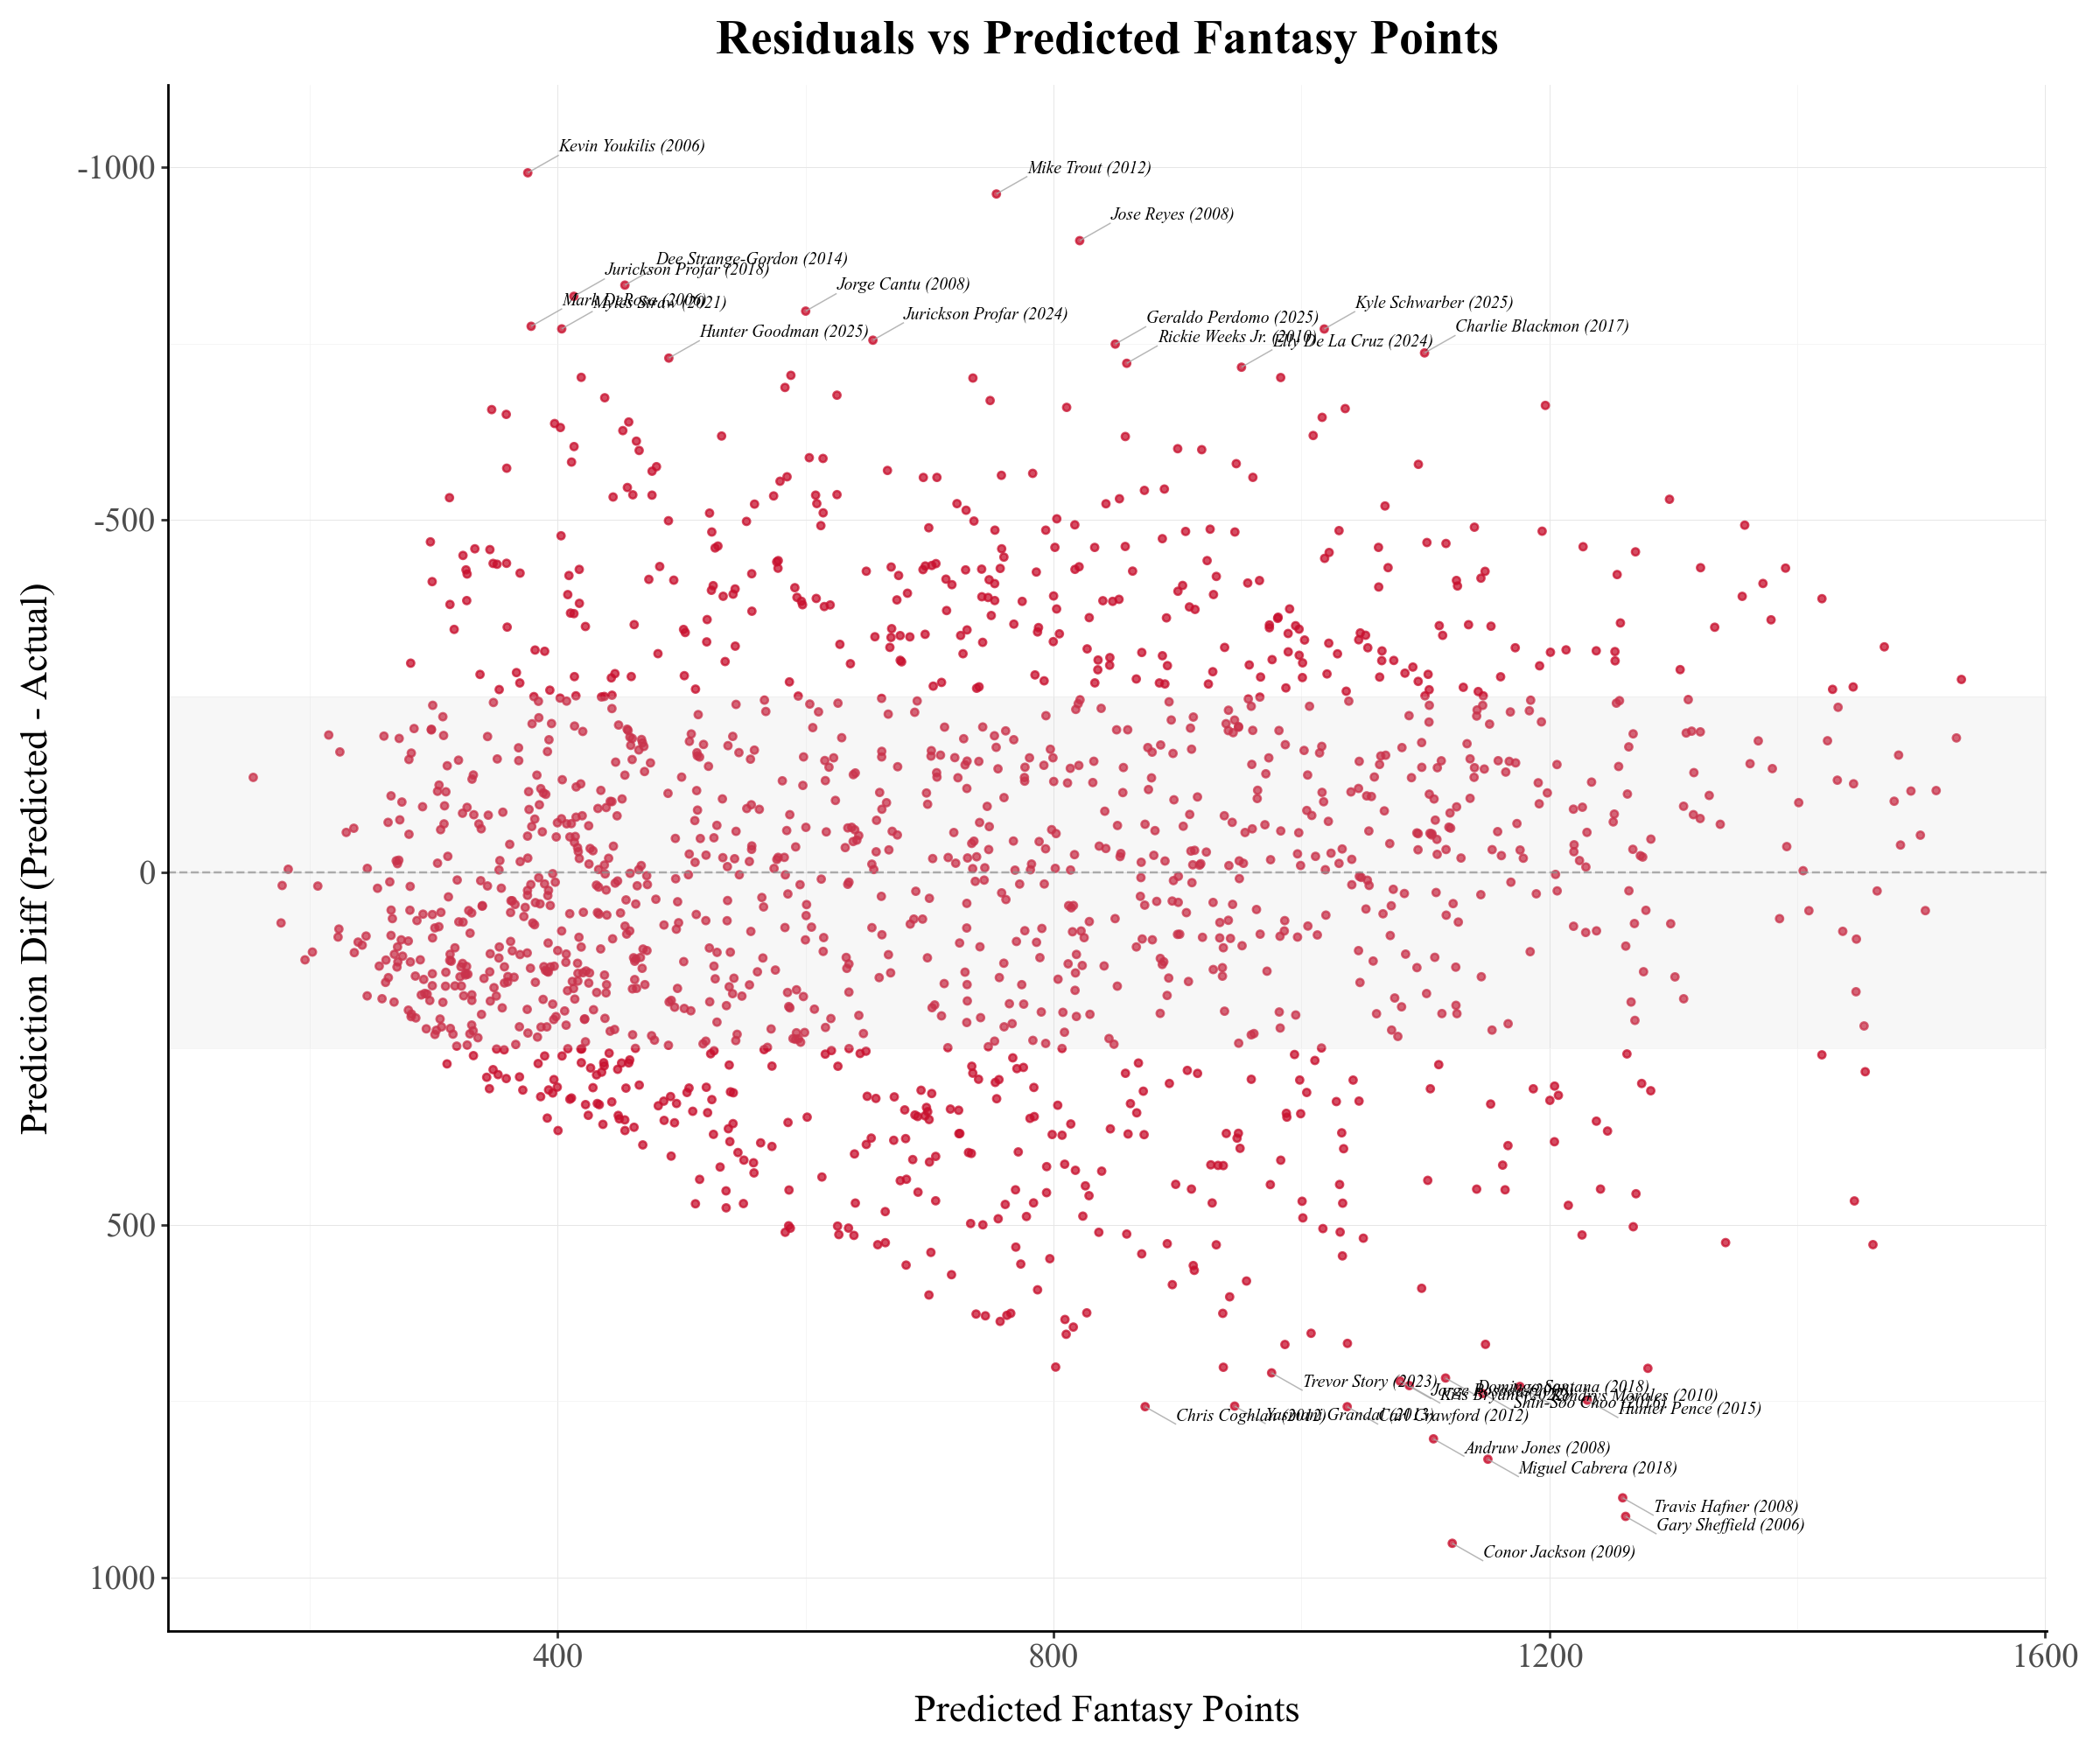

In [116]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

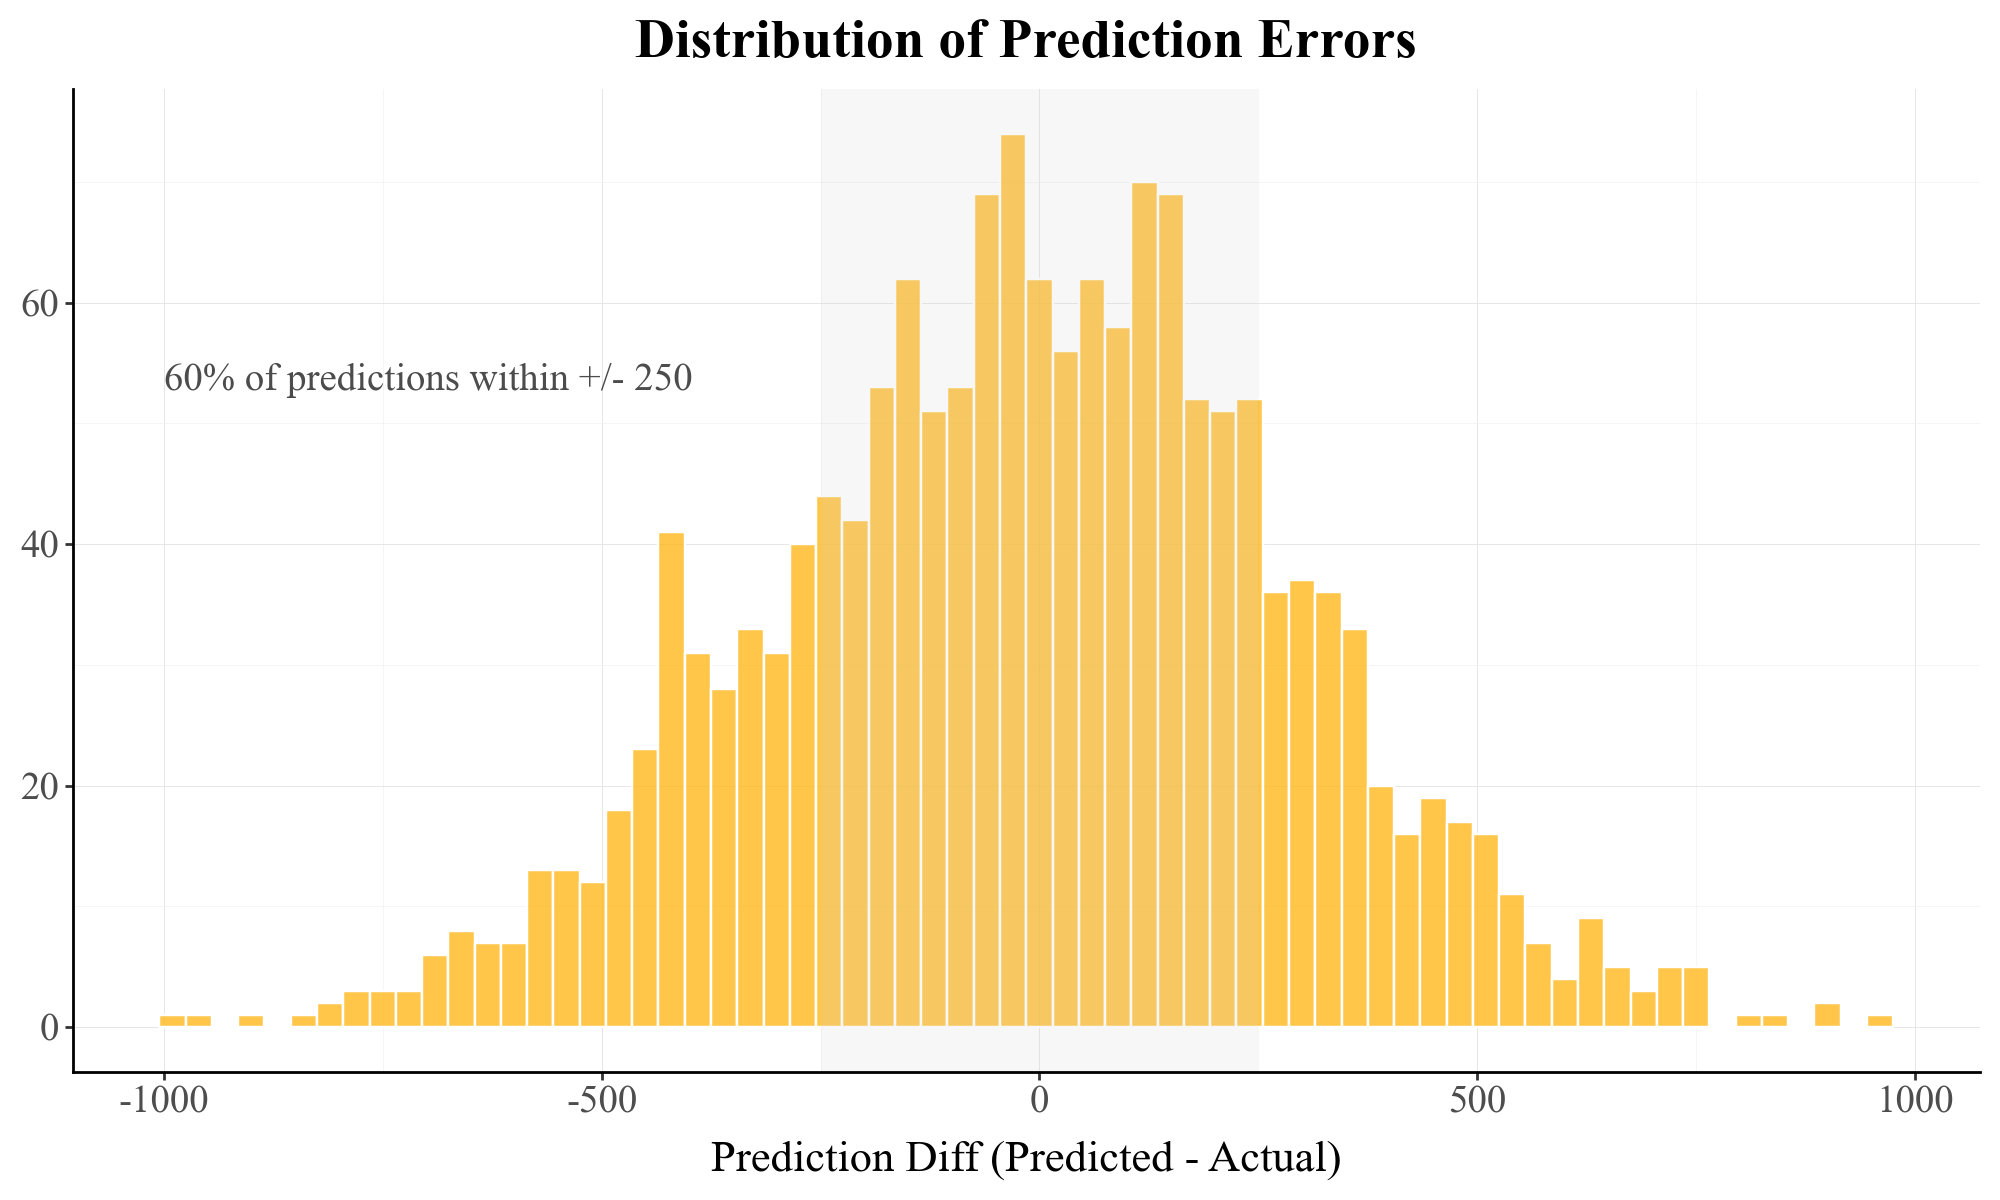

In [117]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

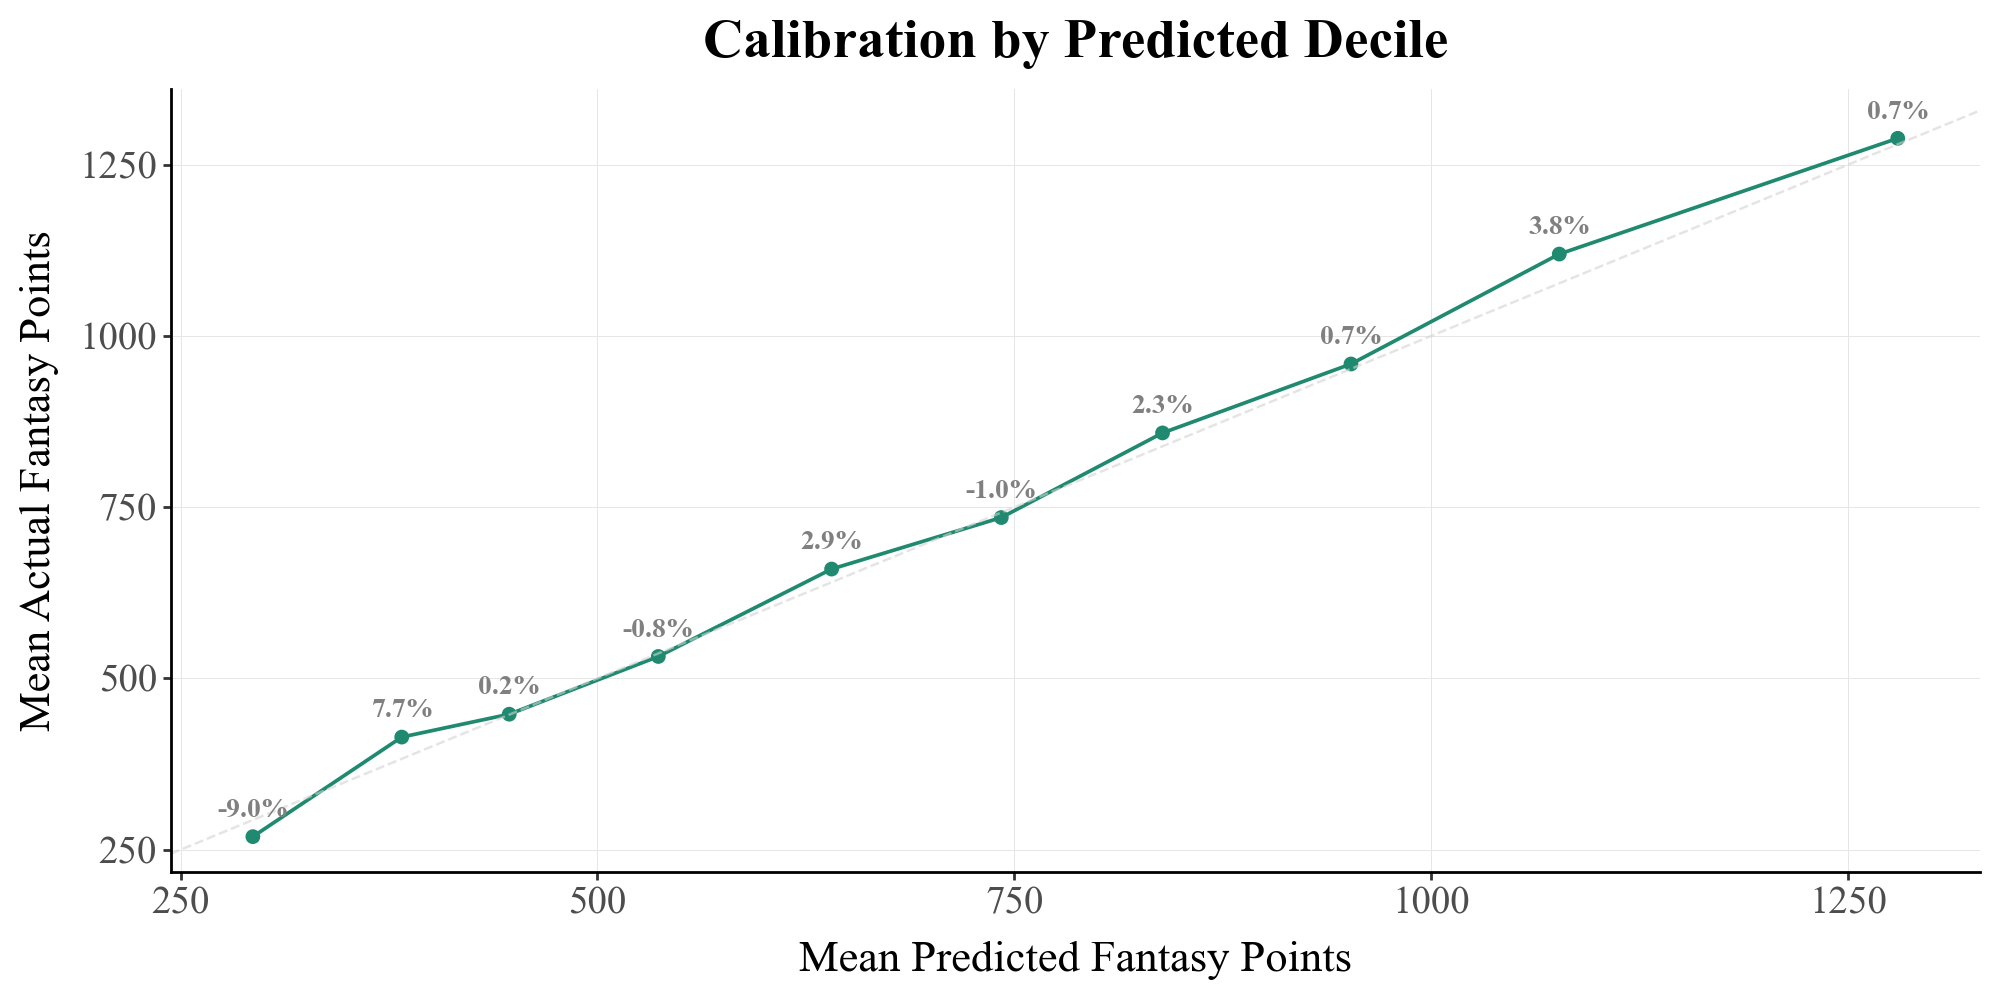

In [118]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [119]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 196.350 | MAE: 147.351 | R^2: 0.516


In [120]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
13       Max Scherzer                 1132.3               1243.186646   
619   Felix Hernandez                 1193.0               1233.961670   
880      Tim Lincecum                 1166.3               1226.529175   
649     Johan Santana                 1313.6               1175.909790   
1378  Felix Hernandez                 1113.3               1167.523926   
...               ...                    ...                       ...   
1151      Mike Mayers                  208.0                106.044510   
305       Matt Herges                  229.0                100.106689   
1140     David Phelps                  118.6                 97.979141   
1494   T.J. McFarland                   72.6                 95.621735   
1099       Sam Howard                  127.0                 84.789322   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
13         110.886646     110.886646    2018   33          1464.6  
619         40.961670      40.961670    2011   25          1165.6  
880         60.229175      60.229175    2009   25          1347.3  
649       -137.690210     137.690210    2005   26          1265.6  
1378        54.223926      54.223926    2012   26          1193.0  
...               ...            ...     ...  ...             ...  
1151      -101.955490     101.955490    2019   27            63.0  
305       -128.893311     128.893311    2005   35            50.0  
1140       -20.620859      20.620859    2019   32           181.3  
1494        23.021735      23.021735    2021   32           164.6  
1099       -42.210678      42.210678    2019   26            94.0  

[1525 rows x 8 columns]

# Pitching Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    n_bootstrap=30,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2500,
    early_stopping_rounds=30,
)

100%|██████████| 50/50 [02:24<00:00,  2.89s/trial, best loss: 194.89003052359948]
Best Parameters: {'learning_rate': 0.02617660923239533, 'max_leaves': 66, 'grow_policy': 'lossguide', 'subsample': 0.8433984480130331, 'colsample_bytree': 0.7167543529733333, 'min_child_weight': 13.817205862402092, 'reg_lambda': 0.01614740660768568, 'reg_alpha': 0.0010220795381299245, 'gamma': 0.1018912126989418}
[Best trial @ val] optimized=rmse | RMSE=194.890 | MAE=146.033 | ASYM=48606.390


In [ ]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=SEED,
    id_cols=["IDfg"],          
)

Best iteration: 310
[Val] RMSE: 194.890 | MAE: 146.033 | R^2: 0.510 | ASYM: 48606.390
[Test] RMSE: 195.194 | MAE: 146.485 | R^2: 0.522 | ASYM: 47914.264


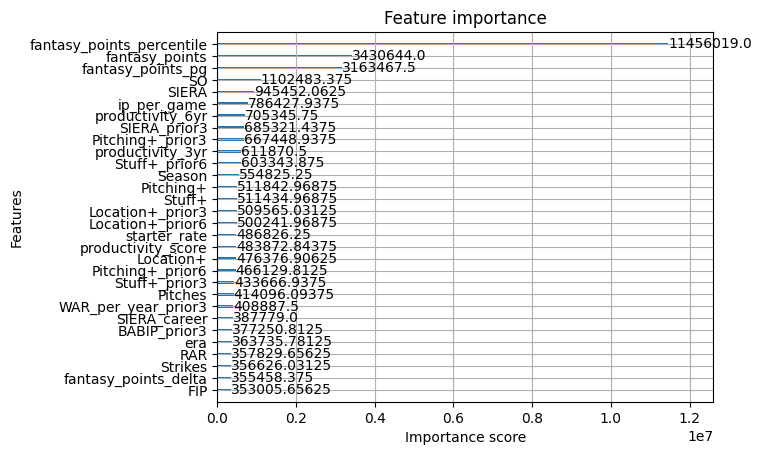

In [ ]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [124]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
649    Johan Santana                 1313.6               1228.613403   
13      Max Scherzer                 1132.3               1224.767822   
880     Tim Lincecum                 1166.3               1189.422485   
1097      Chris Sale                  909.3               1149.784668   
603       Chris Sale                 1444.3               1137.418823   
...              ...                    ...                       ...   
1494  T.J. McFarland                   72.6                127.333961   
1332    Tyler Rogers                  138.0                126.892288   
1519   Yency Almonte                  138.6                125.614677   
1154    Blake Parker                  123.0                120.679893   
566   T.J. McFarland                   67.6                 97.240234   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
649        -84.986597      84.986597    2005   26          1265.6  
13          92.467822      92.467822    2018   33          1464.6  
880         23.122485      23.122485    2009   25          1347.3  
1097       240.484668     240.484668    2018   29          1134.0  
603       -306.881177     306.881177    2016   27          1210.6  
...               ...            ...     ...  ...             ...  
1494        54.733961      54.733961    2021   32           164.6  
1332       -11.107712      11.107712    2019   28           103.6  
1519       -12.985323      12.985323    2019   25           126.0  
1154        -2.320107       2.320107    2019   34           300.3  
566         29.640234      29.640234    2019   30           183.0  

[1525 rows x 8 columns]

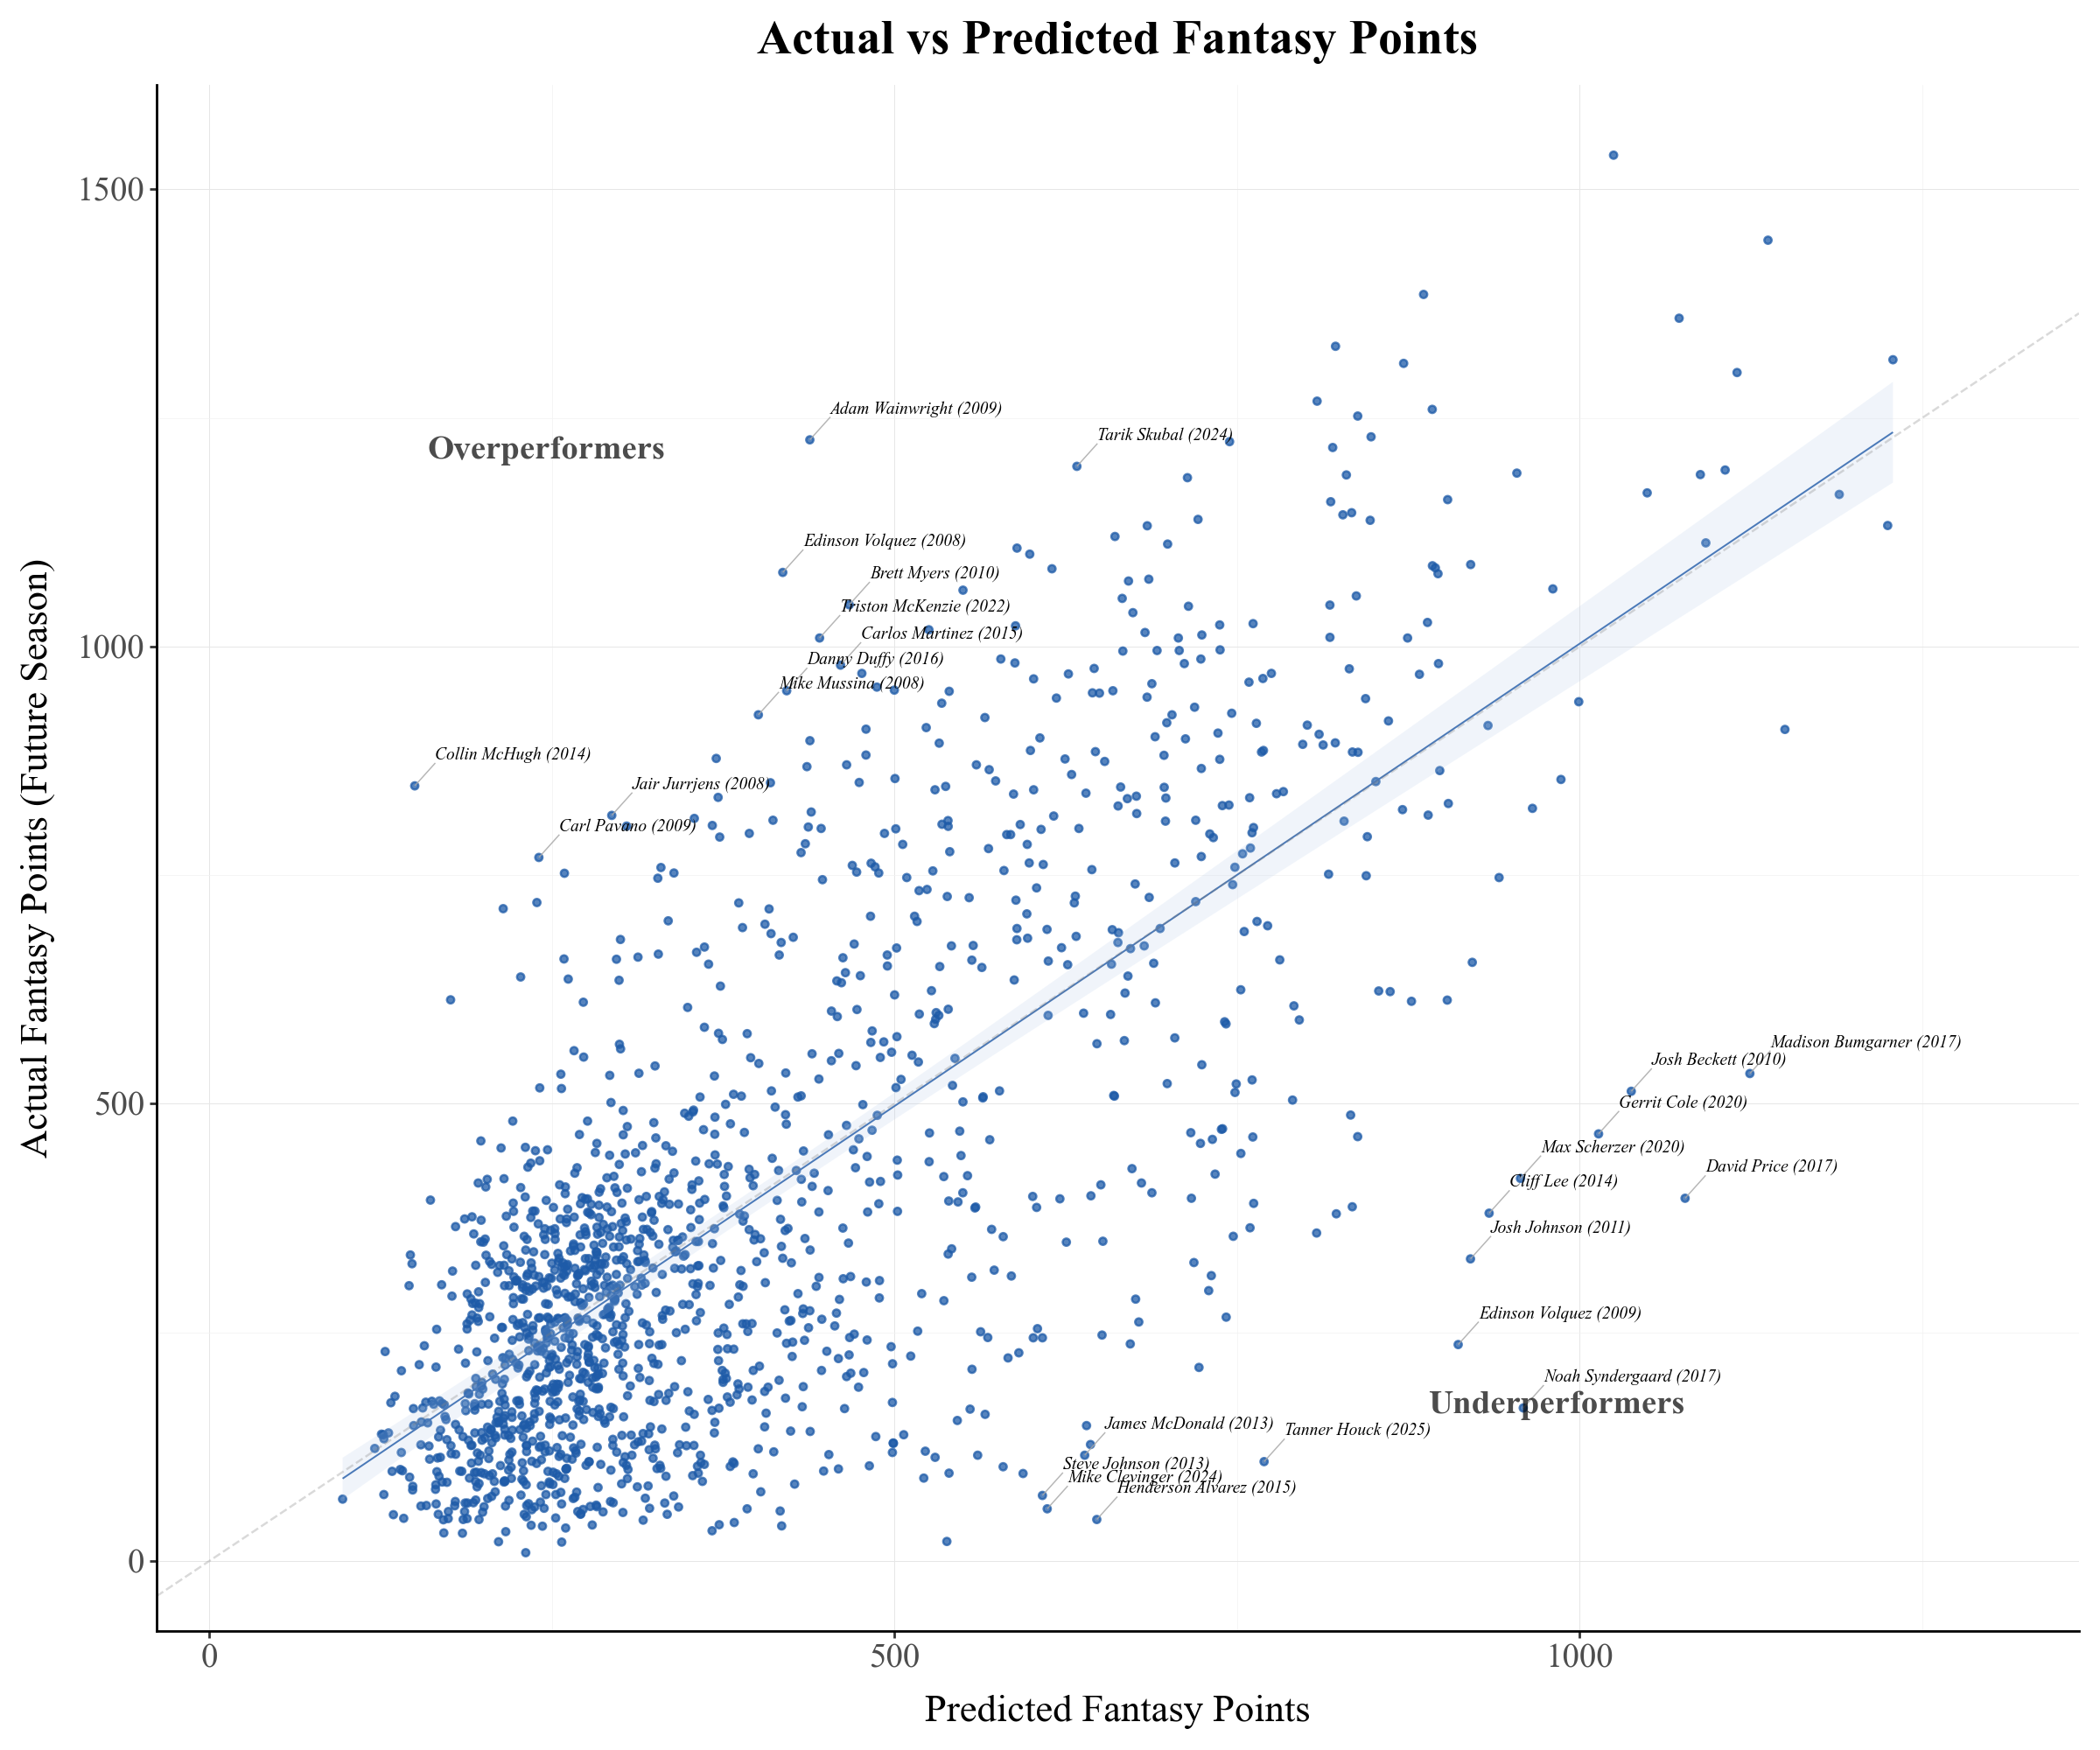

In [125]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

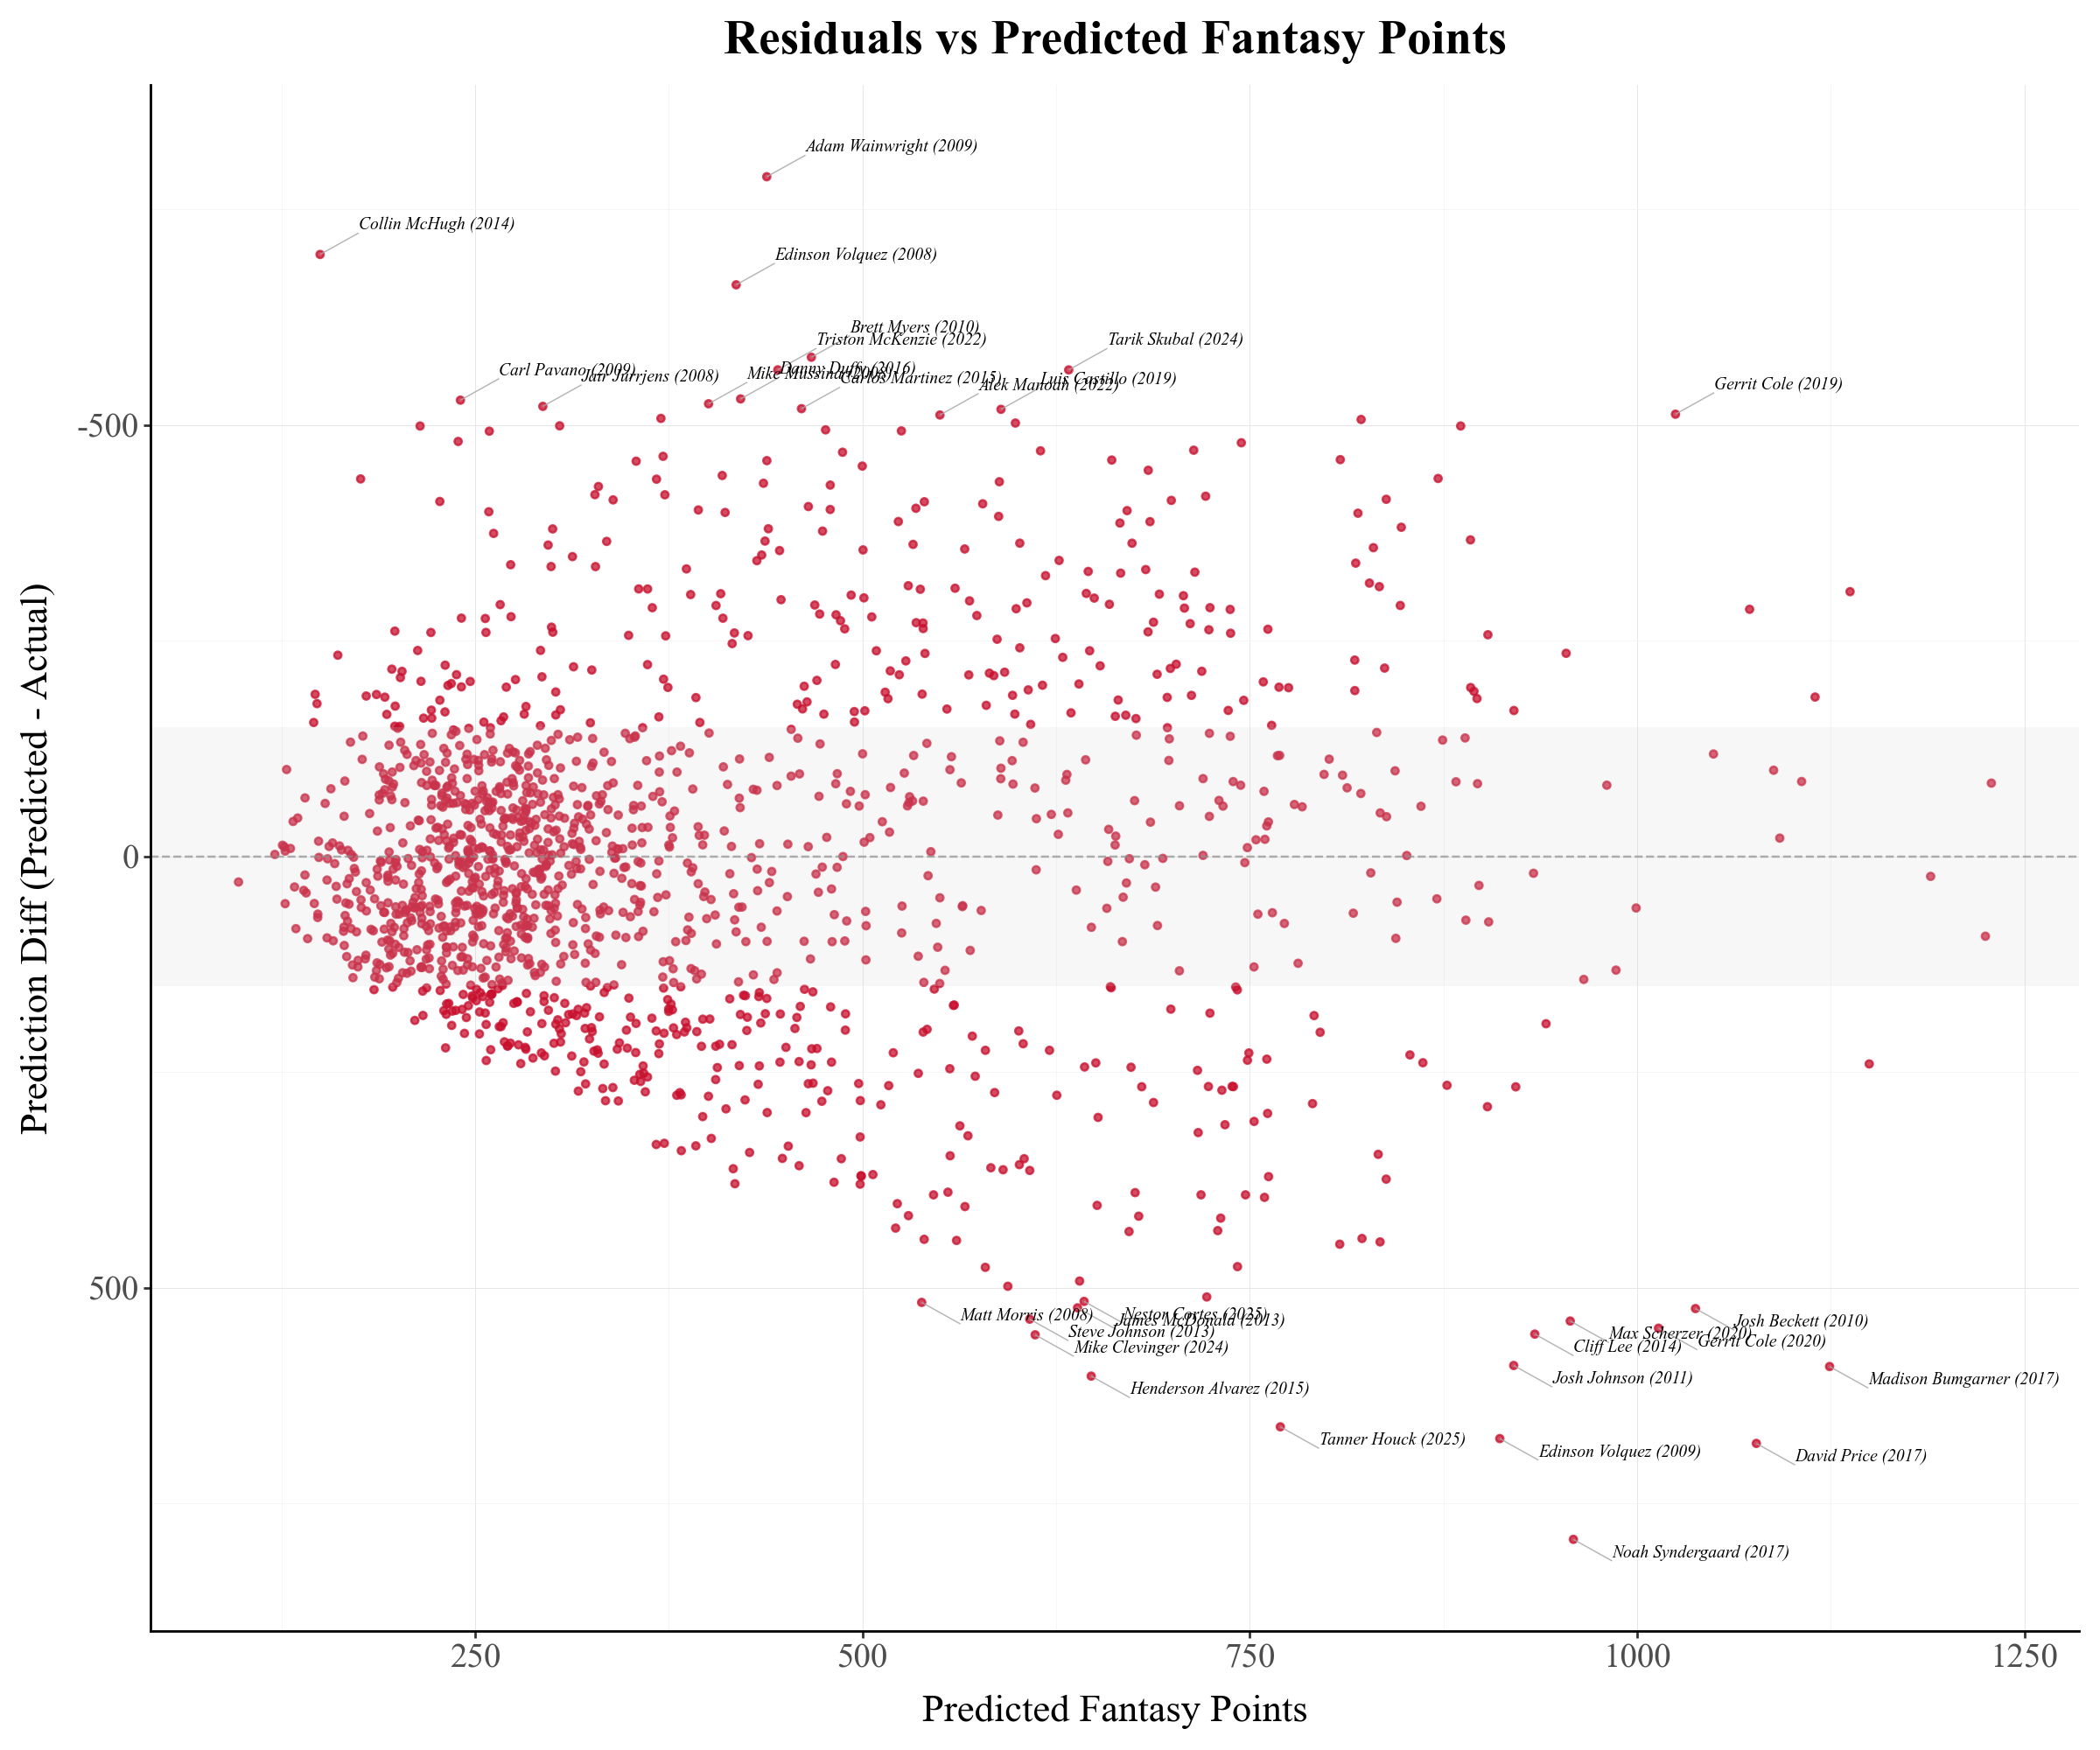

In [126]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

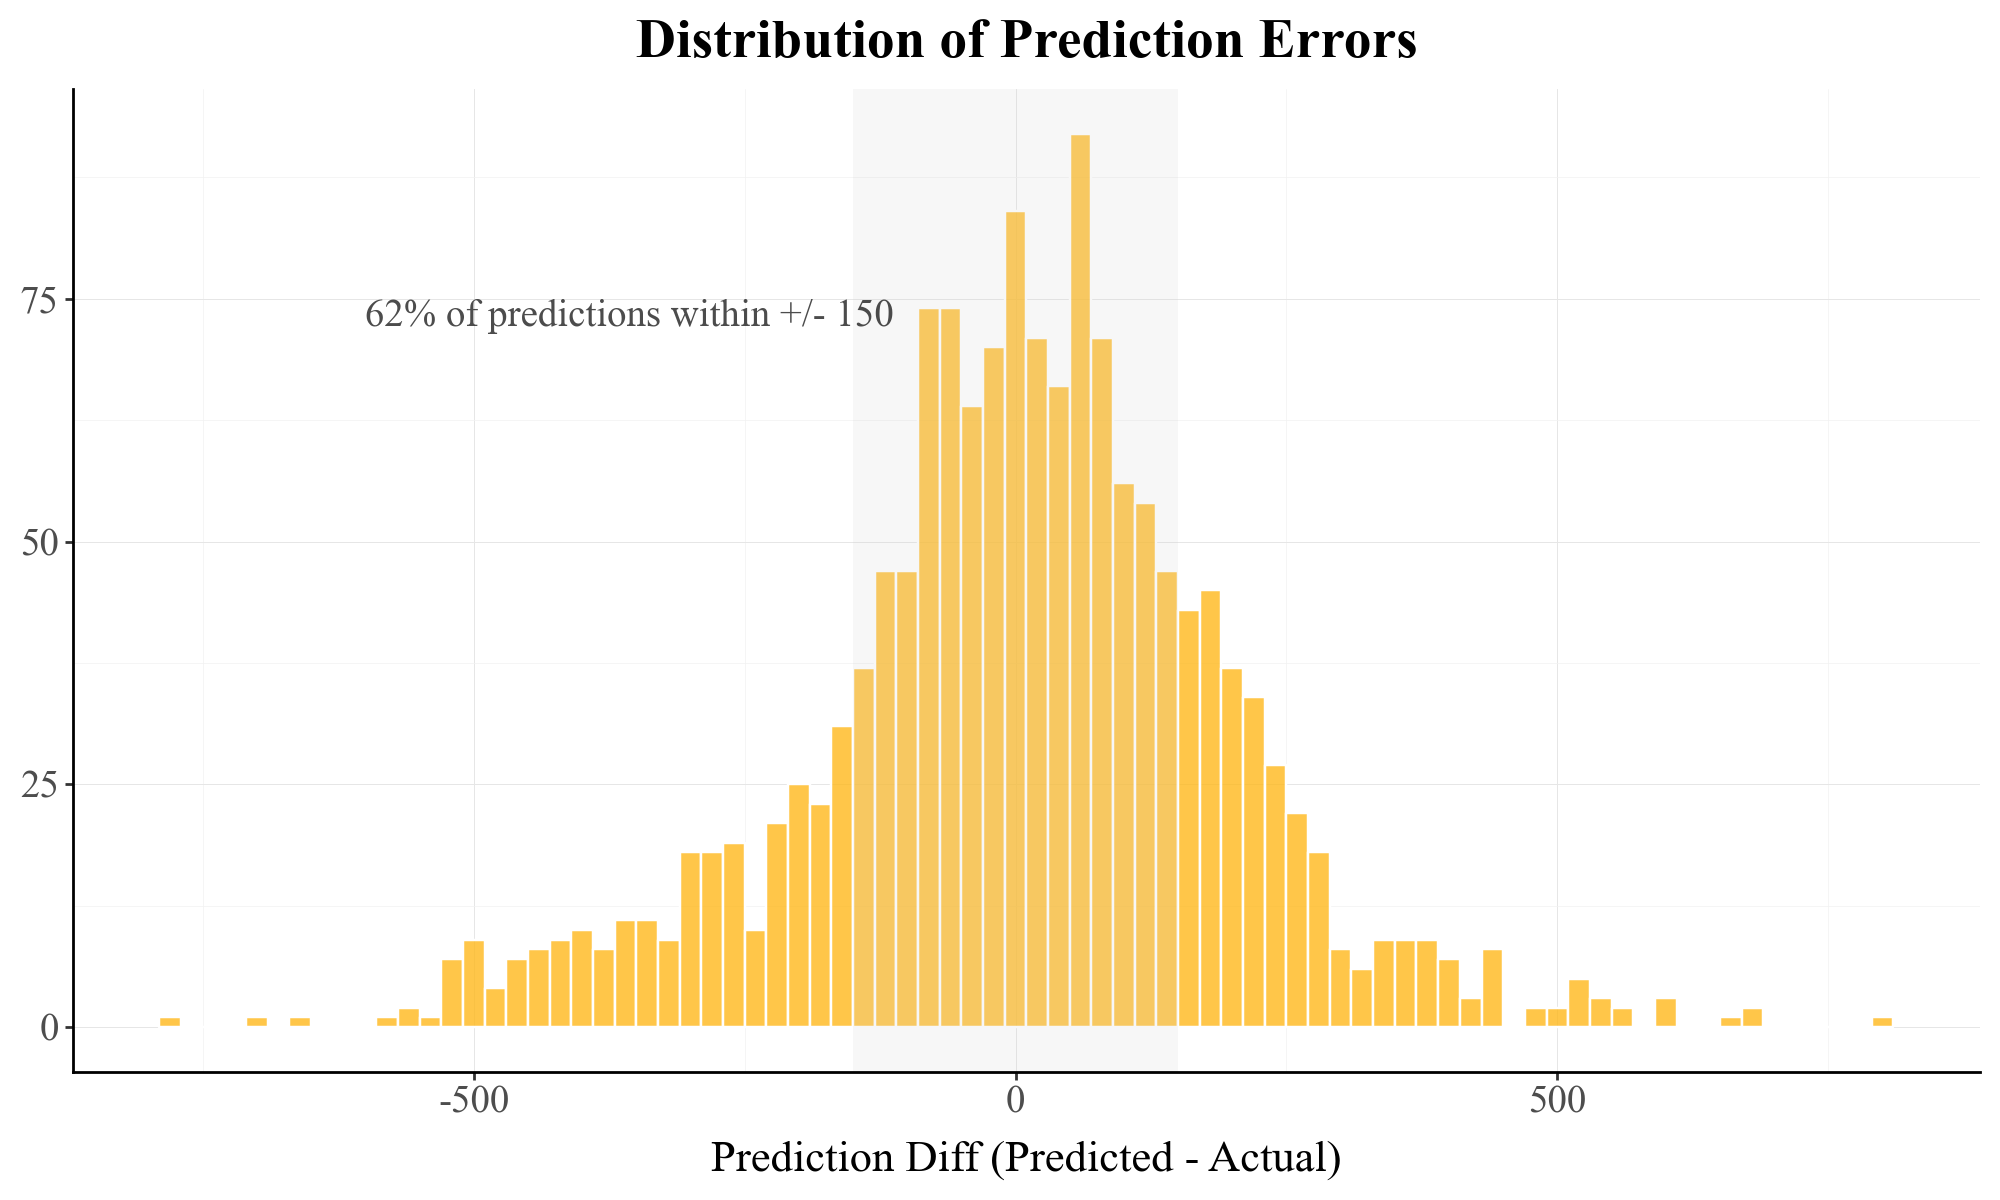

In [127]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=20,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

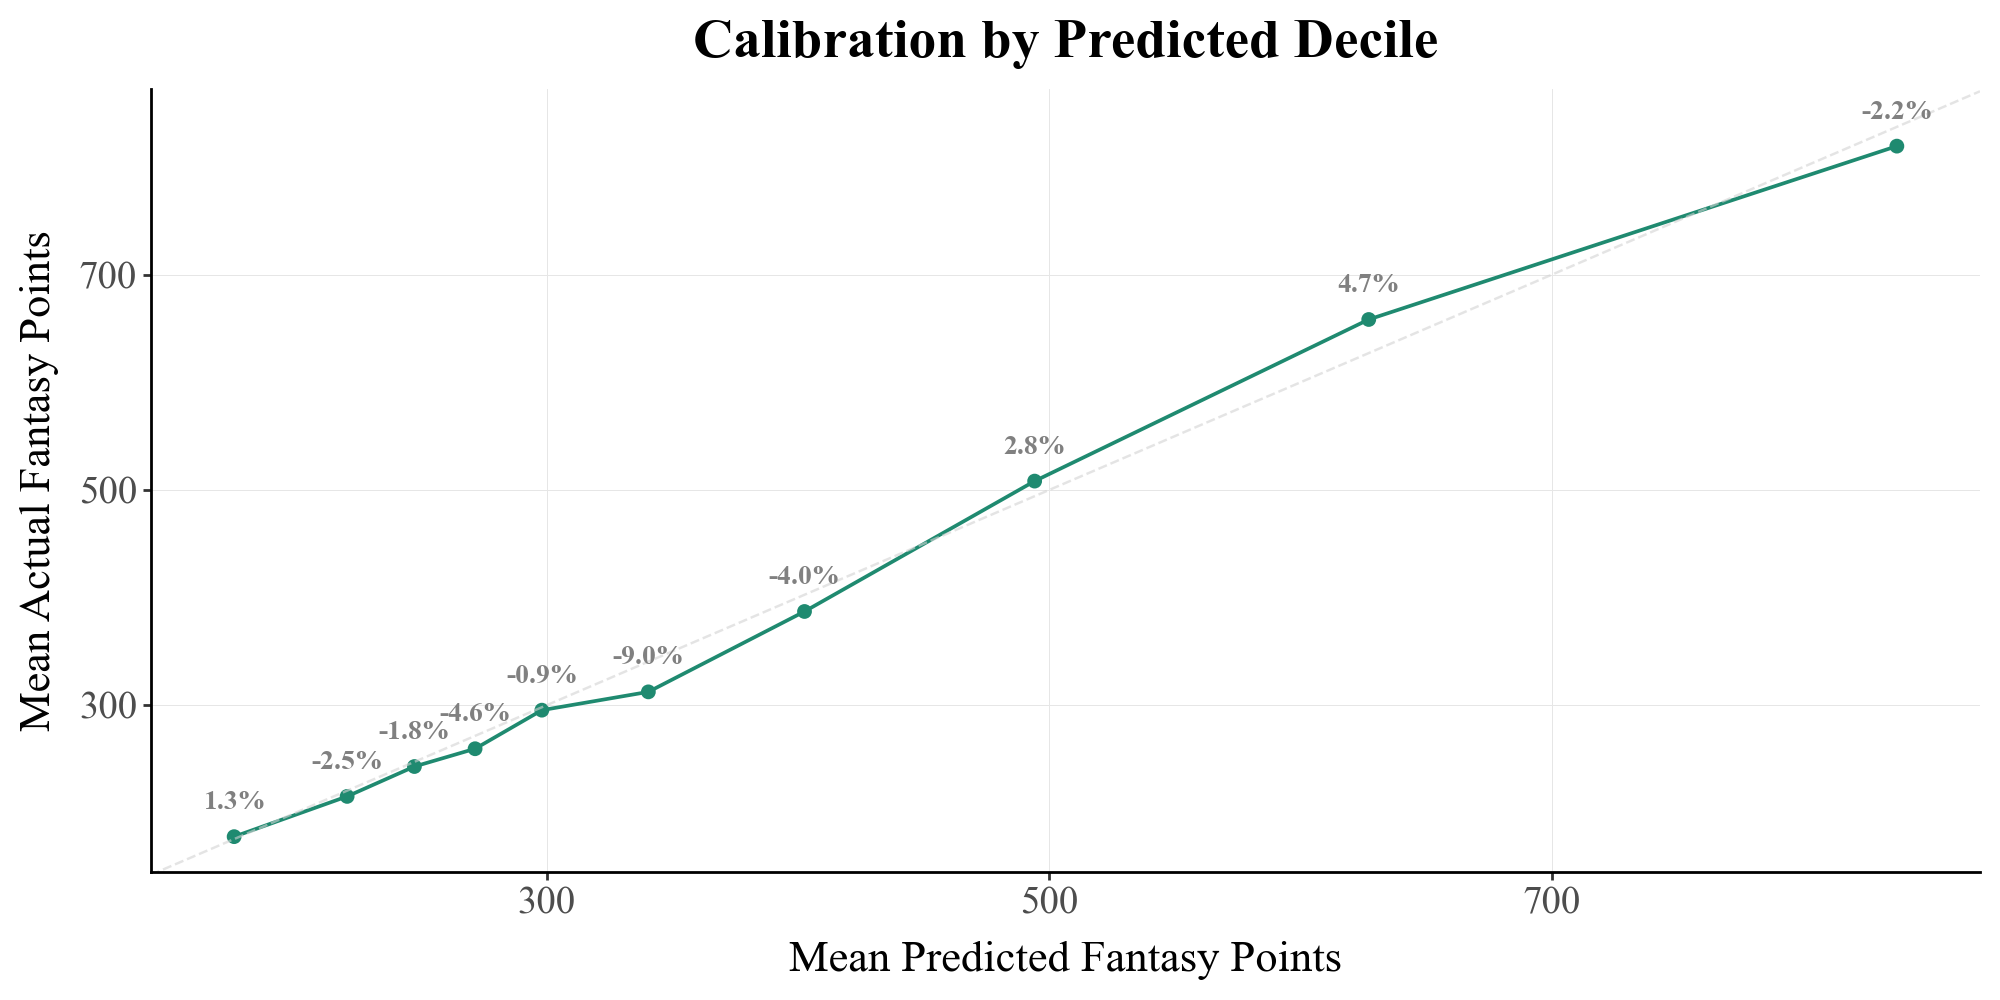

In [128]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [129]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [130]:
display(batting_pred)

IDfg  Season              Name  Age    G   AB    H   1B  2B  3B  ...  \
92   15640    2025       Aaron Judge   33  152  541  179   94  30   2  ...   
228  20123    2025         Juan Soto   26  160  577  152   88  20   1  ...   
203  19755    2025     Shohei Ohtani   30  158  611  172   83  25   9  ...   
319  23697    2025   Julio Rodriguez   24  160  652  174  107  31   4  ...   
389  26289    2025  Gunnar Henderson   24  154  577  158  102  34   5  ...   
..     ...     ...               ...  ...  ...  ...  ...  ...  ..  ..  ...   
9     6887    2025  Martin Maldonado   38   64  147   30   20   6   0  ...   
124  17040    2025      Jose Herrera   28   58  166   31   23   6   0  ...   
67   13723    2025   Jacob Stallings   35   43  119   16   12   4   0  ...   
456  29524    2025    Bryce Teodosio   26   50  138   28   18   7   2  ...   
357  25434    2025       Will Wilson   26   34   78   15   11   4   0  ...   

     fantasy_points_percentile  fantasy_points_pred    pred_mean     pred_p10  \
92                  100.000000          1695.561279  1530.547729  1300.801147   
228                  99.627561          1622.966797  1581.030151  1448.431641   
203                  99.813780          1622.583740  1621.416016  1424.053711   
319                  97.765363          1487.293701  1442.588745  1355.299805   
389                  93.482309          1456.885864  1386.252930  1298.812012   
..                         ...                  ...          ...          ...   
9                    21.973929           243.791138   230.565826   185.907166   
124                  30.912477           240.338486   242.038589   216.683640   
67                    8.007449           231.889542   247.583206   204.507065   
456                  23.277467           230.303909   269.733795   211.144196   
357                   6.610801           222.676239   229.330246   185.520050   

        pred_p50     pred_p90  pred_upside  pred_downside  implied_upside  \
92   1544.044067  1713.197266   182.649536     229.746582        0.745350   
228  1593.209229  1717.136353   136.106201     132.598511        0.917103   
203  1654.029419  1785.151978   163.735962     197.362305        0.766639   
319  1449.139893  1513.802368    71.213623      87.288940        0.700130   
389  1384.964111  1468.656616    82.403687      87.440918        0.813434   
..           ...          ...          ...            ...             ...   
9     228.816803   276.122162    45.556335      44.658661        0.970020   
124   245.190216   272.276306    30.237717      25.354950        1.088654   
67    249.281754   286.639465    39.056259      43.076141        0.857400   
456   275.862183   318.933441    49.199646      58.589600        0.802775   
357   229.541641   276.740295    47.410049      43.810196        1.028340   

     pred_width_80  
92      412.396118  
228     268.704712  
203     361.098267  
319     158.502563  
389     169.844604  
..             ...  
9        90.214996  
124      55.592667  
67       82.132401  
456     107.789246  
357      91.220245  

[537 rows x 218 columns]

In [131]:
display(pitching_pred)

IDfg  Season                Name  Age   G  GS  Pitches  Strikes   W  \
186  17995    2025          Logan Webb   28  34  34     3282     2165  15   
335  22267    2025        Tarik Skubal   28  31  31     2849     2003  13   
575  33677    2025         Paul Skenes   23  32  32     2997     1952  10   
279  20778    2025  Cristopher Sanchez   28  32  32     2897     1941  13   
411  25880    2025        Hunter Brown   26  31  31     2964     1832  12   
..     ...     ...                 ...  ...  ..  ..      ...      ...  ..   
29   11121    2025      Casey Lawrence   37   6   0      276      179   1   
192  18347    2025     Brandon Waddell   31  11   1      513      315   0   
371  24203    2025        Luis Peralta   24  22   0      436      250   1   
543  31552    2025          Zach Agnos   24  30   0      527      309   1   
424  26203    2025    Andrew Saalfrank   27  28   0      427      271   2   

     WAR  ...  fantasy_points_percentile  fantasy_points_pred    pred_mean  \
186  5.5  ...                  99.661017          1047.595947  1006.791321   
335  6.6  ...                  99.830508           989.950073   926.611816   
575  6.5  ...                  99.322034           967.806458   893.465637   
279  6.4  ...                  99.491525           943.285828   922.696716   
411  4.6  ...                  99.067797           908.089539   873.506470   
..   ...  ...                        ...                  ...          ...   
29   0.0  ...                   2.033898           135.434967   179.209152   
192 -0.1  ...                  19.491525           128.336456   173.042664   
371 -0.7  ...                   1.355932           127.335518   159.842453   
543 -0.4  ...                   8.983051           123.381477   152.732697   
424  0.5  ...                  23.728814           109.540138   169.048630   

       pred_p10     pred_p50     pred_p90  pred_upside  pred_downside  \
186  937.614136  1001.170532  1063.252686    56.461365      69.177185   
335  839.223328   930.970886  1004.723389    78.111572      87.388489   
575  803.779541   904.590637   977.715088    84.249451      89.686096   
279  879.961792   929.679504   965.274963    42.578247      42.734924   
411  805.744751   878.287415   937.846069    64.339600      67.761719   
..          ...          ...          ...          ...            ...   
29   146.643860   176.333664   212.280975    33.071823      32.565292   
192  139.212036   171.145798   204.773071    31.730408      33.830627   
371  136.294266   160.593704   184.469421    24.626968      23.548187   
543  123.074623   154.057861   177.235580    24.502884      29.658073   
424  144.747818   170.753052   190.321045    21.272415      24.300812   

     implied_upside  pred_width_80  
186        0.712490     125.638550  
335        0.808152     165.500061  
575        0.854277     173.935547  
279        0.819413      85.313171  
411        0.841076     132.101318  
..              ...            ...  
29         0.962583      65.637115  
192        0.892280      65.561035  
371        0.979335      48.175156  
543        0.785717      54.160957  
424        0.818444      45.573227  

[590 rows x 227 columns]

In [132]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [133]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
494  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
495  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
496  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
497  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...    pred_p90  pred_upside  pred_downside  implied_upside  \
494  ...  903.811584    75.489624      58.999573        1.121975   
495  ...  903.811584    75.489624      58.999573        1.121975   
496  ...  505.600739    57.428040      65.055695        0.825858   
497  ...  505.600739    57.428040      65.055695        0.825858   

     pred_width_80  first_name  last_name  Team  Positions  \
494     134.489197         max      muncy   LAD         3B   
495     134.489197         max      muncy   ATH   2B,3B,SS   
496     122.483734         max      muncy   LAD         3B   
497     122.483734         max      muncy   ATH   2B,3B,SS   

     projected_fantasy_points  
494                     889.0  
495                     602.0  
496                     889.0  
497                     602.0  

[4 rows x 223 columns]

In [134]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
4    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
746  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
747  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
748  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
749  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
750  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...     pred_p90  pred_upside  pred_downside  implied_upside  \
0     NaN  ...          NaN          NaN            NaN             NaN   
1     2.0  ...  1713.197266   182.649536     229.746582        0.745350   
2     NaN  ...          NaN          NaN            NaN             NaN   
3     NaN  ...          NaN          NaN            NaN             NaN   
4     0.0  ...   526.428772    31.299866      31.293396        0.863571   
..    ...  ...          ...          ...            ...             ...   
746   0.0  ...   432.208496    62.229187      69.780457        0.846883   
747  11.0  ...   801.383972    57.940186      60.499084        0.852895   
748   1.0  ...  1188.877075    65.606689      80.992065        0.711378   
749   0.0  ...   594.637146   103.627502      78.261108        1.245954   
750   0.0  ...   369.279053    51.495178      52.067963        0.932110   

     pred_width_80  first_name  last_name  Team    Positions  \
0              NaN        a.j.   vukovich   ARI        3B,LF   
1       412.396118       aaron      judge   NYY  LF,CF,RF,DH   
2              NaN       aaron     schunk   ATL     2B,3B,SS   
3              NaN    abimelec      ortiz   WSH        1B,OF   
4        62.593262     abraham       toro    KC     1B,2B,3B   
..             ...         ...        ...   ...          ...   
746     132.009644        zach    dezenzo   HOU        LF,RF   
747     118.439270        zach  mckinstry   DET  3B,SS,LF,RF   
748     146.598755        zach       neto   LAA           SS   
749     181.888611        zack      gelof   ATH           2B   
750     103.563141        zack      short   NaN          NaN   

     projected_fantasy_points  
0                        67.0  
1                      1706.0  
2                        44.0  
3                       145.0  
4                        77.0  
..                        ...  
746                     145.0  
747                     741.0  
748                    1295.0  
749                     253.0  
750                       NaN  

[749 rows x 223 columns]

In [135]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [136]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
904  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
905  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
906  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
907  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
908  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...    pred_p90  pred_upside  pred_downside  implied_upside  \
0     3.0  0.1  ...  497.131348    63.130615      54.713837        1.069035   
1     NaN  NaN  ...         NaN          NaN            NaN             NaN   
2     NaN  NaN  ...         NaN          NaN            NaN             NaN   
3     NaN  NaN  ...         NaN          NaN            NaN             NaN   
4     5.0  1.2  ...  411.406952    35.380096      32.485352        0.976121   
..    ...  ...  ...         ...          ...            ...             ...   
904   1.0  0.4  ...  274.525360    16.302856      17.221695        0.823214   
905  10.0  1.5  ...  513.156677    52.382812      53.698334        0.898411   
906  10.0  4.0  ...  904.816956    89.036011      95.346680        0.860214   
907   1.0  0.1  ...  264.999084    48.421478      41.960175        1.097347   
908   5.0  1.4  ...  555.512146    54.249695      54.399384        0.913110   

     pred_width_80  first_name  last_name  Team  Positions  \
0       117.844452        a.j.   blubaugh   NaN        NaN   
1              NaN        a.j.     causey    KC          P   
2              NaN        a.j.     minter   NYM         RP   
3              NaN        a.j.        puk   ARI         RP   
4        67.865448       aaron      ashby   MIL         RP   
..             ...         ...        ...   ...        ...   
904      33.524551        zack      kelly   BOS      SP,RP   
905     106.081146        zack    littell   NaN         SP   
906     184.382690        zack    wheeler   PHI         SP   
907      90.381653         zak       kent   TEX         RP   
908     108.649078       zebby   matthews   MIN         SP   

     projected_fantasy_points  
0                         NaN  
1                        77.9  
2                       331.5  
3                       184.0  
4                       345.0  
..                        ...  
904                     263.1  
905                     669.5  
906                     722.7  
907                     184.3  
908                     580.4  

[909 rows x 232 columns]

In [137]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [138]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [139]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points',
                               'pred_downside', 'pred_upside', 'pred_width_80', 'implied_upside']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

# Finalizing Predictions & Creating Relative Positional Value Scores

In [140]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [141]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [142]:
# Creating final projected score, with 67% weight being placed on predictions and 33% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [143]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [144]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [145]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [146]:
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [147]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)


In [148]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [149]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

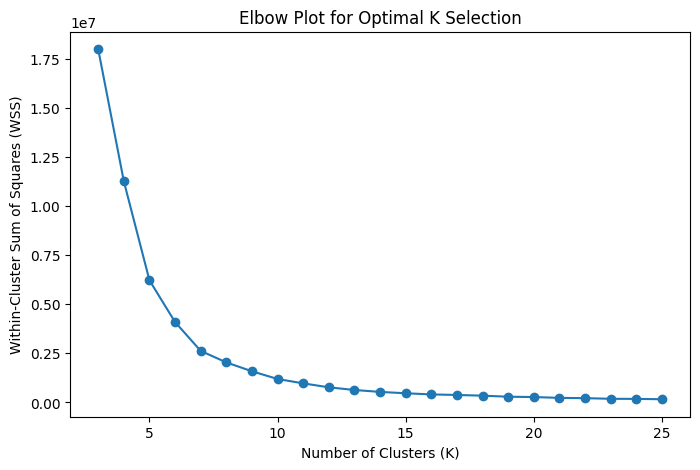

In [150]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [151]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [152]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [153]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)